In [2]:
pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 6.9 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633986 sha256=efcdbc3192461832bef6755d3d3bac9f8dcc11d244e289774bb8ac6c1a12b933
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [3]:
#importing the necessary packages
import numpy as np
import pandas as pd
from surprise import Reader
from surprise import KNNWithMeans
from surprise import Dataset
import pickle

We have created the movies dataframe from the data pulled out of the kafka log. The movie_df_csv contains folowwing columns:

1) userid : unique id that represents a user

2) movieid: unique id that represents a movie

3) date_watch: the date when the movie was watched

4) time_watch: the exact time when the movie was watched

5) minutes: the number of minutes a user spent watching the movie

6) rating: the rating on a scale of 1-5 given by the user

## EDA and Understanding the Data

In [5]:
#movie_df_csv = pd.read_csv('sample-user-movie-df.csv')
movie_df_csv = pd.read_csv('watched_rated_df.csv')

In [6]:
len(movie_df_csv)

153041

In [7]:
movie_df_csv.head()

,userid,movieid,date_watch,time_watch,minutes,date_rate,time_rate,rating
0,122183,raising+arizona+1987,2022-08-11,20:23:23,92,2022-08-11,20:27:16,4
1,79445,the+piano+1993,2022-08-11,19:29:59,99,2022-08-11,19:54:12,3
2,67863,forrest+gump+1994,2022-08-11,20:39:23,96,2022-08-11,21:27:26,4
3,179877,101+dalmatians+1996,2022-08-11,20:02:43,99,2022-08-11,20:08:37,5
4,224353,the+empire+strikes+back+1980,2022-08-11,21:10:10,99,2022-08-11,21:37:01,4


In [8]:
df_sub = movie_df_csv[['userid','movieid','rating']]

In [9]:
reader = Reader(rating_scale=(1, 5))

In [10]:
# df_sub = Dataset.load_from_df(df_sub[['userid','movieid','rating']], reader)

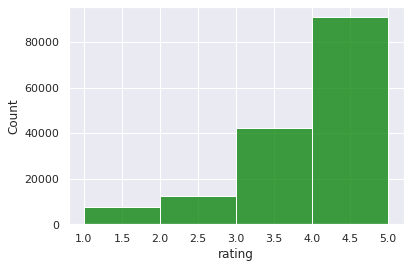

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid",color_codes=True)
pal = sns.color_palette("Greens_d", len(df_sub['rating']))
rank = df_sub['rating'].argsort().argsort() 
sns.histplot(data=df_sub['rating'],binwidth=1,palette=np.array(pal[::-1])[rank],color="green")
plt.show()

## MEMORY BASED CF USING KNN

We implement a memory based Collaborative filtering model using K Nearest Neighbors. It computes the cosine distances between each target movie and every other movie in the database and returns the top K nearest neighbor movies as most similar recommendations.

In [12]:
from surprise.model_selection import cross_validate

In [13]:
algo = KNNWithMeans()

In [14]:
from surprise import accuracy, Dataset, SVD

#we split the dataset into a 80-20 split for training and testing
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_sub, test_size=0.2)

In [15]:
#implementing GridsearchCV to find the optimal set of hyperparamaeters to use
from surprise.model_selection import GridSearchCV

data_train = Dataset.load_from_df(train[['userid','movieid','rating']], reader)

sim_options = {
    "name": ["cosine"],
    "min_support": [3, 4, 5],
    "user_based": [False, True],
}
param_grid = {"sim_options": sim_options}
gs = GridSearchCV(KNNWithMeans, param_grid, measures=["rmse"], cv=4)
gs.fit(data_train)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing th

In [16]:
trainingSet = data_train.build_full_trainset()

In [17]:
knn_algo = KNNWithMeans(sim_options=gs.best_params)
knn_algo.fit(trainingSet)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [18]:
#this function returns the root mean squared error between two arrays
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [19]:
#calculating the performance of the model on the test dataset
from tqdm import tqdm
predictions = []
actuals = []
rmse_val = []
for col, row in tqdm(test.iterrows()):
    predictions.append(knn_algo.predict(row.userid, row.movieid).est)
    actuals.append(row.rating)

30609it [00:10, 3033.85it/s]


In [20]:
rmse_val = rmse(np.array(predictions), np.array(actuals))

In [21]:
print("Test RMSE KNN = " + str(rmse_val))

Test RMSE KNN = 0.9924231350270729


In [22]:
"""
The following function fetches a list of movies a user has not watched and uses the model to predict what rating 
they would give to that movie. We then take the top 20 predicted ratings of unwatched movies and recommend them to 
a particular user. 
"""
import random
master_movie_list = movie_df_csv['movieid'].unique().tolist()
top_20 = movie_df_csv.groupby(['movieid']).mean().rating.sort_values(0, ascending = False)[0:20]
top_20_tup = [(top_20.index[i], top_20.values[i]) for i in range(len(top_20.values))]
def get_recommendations(userId,model):
    if(userId not in movie_df_csv['userid'].values.tolist()):
        return random.sample(top_20_tup, len(top_20_tup))
    watched_list = movie_df_csv[movie_df_csv['userid'] == userId]['movieid'].unique().tolist()
    pred_movies = [i for i in master_movie_list if i not in watched_list]
    pred_dict = dict()
    for i in pred_movies:
        pred_dict[i] = model.predict(userId, i).est
    pred_dict = sorted(pred_dict.items(), key=lambda x: -x[1])
    if(len(pred_dict) < 20):
        return pred_dict
    else:
        return pred_dict[:20]
    return pred_dict

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: In a future version of pandas all arguments of Series.sort_values will be keyword-only
  


In [23]:
#Writing the model to a pickle file
filename = 'KNN_14k'
outfile = open(filename,'wb')
pickle.dump(knn_algo,outfile)
outfile.close()

In [24]:
#Sample inference - In case the movie id does not exist the fucntion just recommends the top 20 movies to a new user
preds = get_recommendations(23422222222222222222222222222222222222,knn_algo)

In [25]:
preds

[('hopscotch+1980', 5.0),
 ('hope+springs+2012', 5.0),
 ('captain+horatio+hornblower+r.n.+1951', 5.0),
 ('carandiru+2003', 5.0),
 ('trailer+park+boys+countdown+to+liquor+day+2009', 5.0),
 ('alice+in+wonderland+1933', 5.0),
 ('phantom+of+the+paradise+1974', 5.0),
 ('the+apple+1998', 5.0),
 ('lucy+2014', 5.0),
 ('boys+life+2+1997', 5.0),
 ('persuasion+2007', 5.0),
 ('the+grass+harp+1995', 5.0),
 ('pianomania+2009', 5.0),
 ('the+good_+the+bad_+the+weird+2008', 5.0),
 ('the+gleaners++i+2000', 5.0),
 ('candleshoe+1977', 5.0),
 ('the+golden+voyage+of+sinbad+1973', 5.0),
 ('lust_+caution+2007', 5.0),
 ('philomena+2013', 5.0),
 ('john+wick+2014', 5.0)]

## Model based CF - Using Singular Value Decomposition (SVD)

This is a model based approach of collaborative filtering and uses singular value decomposition (SVD) a method typically used for dimensionality reduction in machine learning. SVD factorizes the matrix of users and movies and decomposes it into 2 smaller matrices.


In [26]:
from surprise import SVD
from surprise.model_selection import GridSearchCV

"""
lr_all is the learning rate for all parameters (how much the parameters are adjusted in each iteration)
reg_all is the regularization term for all parameters, which is a penalty term added to prevent overfitting.
This creates a model object called svd_algo
"""
param_grid = {
    "n_epochs": [5, 10],
    "lr_all": [0.002, 0.005],
    "reg_all": [0.4, 0.6]
}

# Get the best params using GridSearchCV
gs = GridSearchCV(SVD, param_grid, measures=["rmse"], cv=4)
gs.fit(data_train)
best_params = gs.best_params["rmse"]
print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

# Extract and train model with best params
svd_algo = SVD(n_epochs=best_params['n_epochs'],
               lr_all=best_params['lr_all'],
               reg_all=best_params['reg_all'])
svd_algo.fit(trainingSet)


0.9663411487245215
{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


In [27]:
from tqdm import tqdm
predictions = []
actuals = []
rmse_val = []
for col, row in tqdm(test.iterrows()):
    predictions.append(svd_algo.predict(row.userid, row.movieid).est)
    actuals.append(row.rating)

30609it [00:03, 7686.63it/s]


In [28]:
rmse_val = rmse(np.array(predictions), np.array(actuals))

In [29]:
print("Test RMSE SVD = " + str(rmse_val))

Test RMSE SVD = 0.9527042693086918


In [30]:
#writing the second model to a pickle file
import pickle
filename = 'SVD_14k'
outfile = open(filename,'wb')
pickle.dump(svd_algo,outfile)
outfile.close()